This notebook explores a computational neuromorphic approach to process the cookiebox data

 Imports

In [51]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import h5py
from multiprocess import Pool
from tqdm import tqdm
import math

import matplotlib
matplotlib.style.use('seaborn')

import sys
sys.path.append('../')

import nonuniform_quantization

Helper Functions

In [52]:
def plot_raster(spikes):
    """
    Visualise les trains de décharges.
    
    Args:
        spikes : vecteur 2D des trains de décharges (dims: neurones, temps)
    """

    events_pos = []
    events_neg = []
    for i in range(spikes.shape[0]):
        events_pos.append(np.where(spikes[i, :] == 1)[0])
        events_neg.append(np.where(spikes[i, :] == -1)[0])

    fig, ax = plt.subplots(1, 1)
    ax.eventplot(events_pos, orientation='horizontal', color='b')
    ax.eventplot(events_neg, orientation='horizontal', color='r')
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Delay")
    ax.set_xticks(np.linspace(0, spikes.shape[1], 11))
    ax.set_title("Spike trains (raster plot)")

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

Loading Dataset

In [53]:
# test set
X_test = np.load('../dataset/subset_7bits_opt.npz')['X_test_subset']
Y_test = np.load('../dataset/subset_7bits_opt.npz')['Y_test_subset']

print(X_test.shape)
print(Y_test.shape)

(500, 16, 128, 1)
(500,)


In that example, each channel is considered to be a "neuron" (sensory neuron).

The rester plot shows when each sensory neuron fires

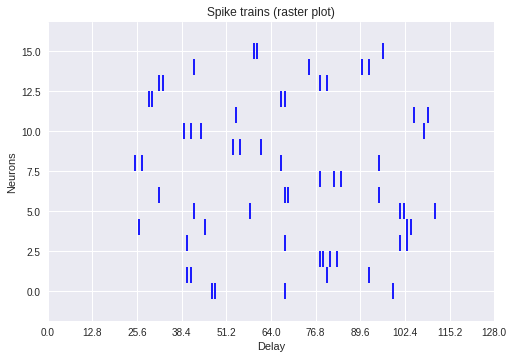

In [50]:
plot_raster(X_test[50,:,:])

### Convert to continuous firing rate with running mean smoothing

Note that in the next plot, each neurone firing rate is offseted to display all neurons in the same graph.

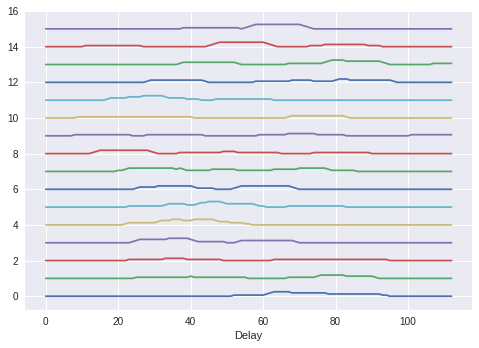

In [46]:
window = 16
X_test_smooth  = np.zeros((X_test.shape[0],X_test.shape[1],X_test.shape[2]-window+1))
for shot in range(X_test.shape[0]):
    for ch in range(X_test.shape[1]):
        # X_train_smooth[shot, ch, :] = preprocessing.normalize([running_mean(X_train_dev[shot, ch, :], window)])
        X_test_smooth[shot, ch, :] = running_mean(X_test[shot, ch, :], window)

for ch in range(X_test_smooth.shape[1]):
        plt.plot(X_test_smooth[0,ch,:]+ch)
        plt.xlabel('Delay')
        
plt.show()

### Let's visualize

In the next cell, we visualize the ralation between the first 3 principal components of the firing rate.

In [48]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

n_components = 3
pca_sim = PCA(n_components=n_components)

color = ['green', 'violet','blue', 'grey', 'orange']

ax = go.Figure()

for shot in range(64):
    temp = X_test_smooth[shot]
    principalComponents = pca_sim.fit_transform(np.swapaxes(temp,0,1))
    marker_dict=dict(
    size=2,
    color=color[Y_test[shot]],   # choose a colorscale
    opacity=0.8
    )
    ax.add_scatter3d(x=principalComponents[:,0], y=principalComponents[:,1], z=principalComponents[:,2],mode='markers', marker=marker_dict)


ax.show()



/sdf/home/b/berthie/git/steve/venv/lib64/python3.6/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide

/sdf/home/b/berthie/git/steve/venv/lib64/python3.6/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide

/sdf/home/b/berthie/git/steve/venv/lib64/python3.6/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide

/sdf/home/b/berthie/git/steve/venv/lib64/python3.6/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



# Now let's try with real dataset

File info (modify according to your environment and dataset)

In [28]:
file_path = '/sdf/home/b/berthie/tmox42619_data/h5files/hits.tmox42619.run135.h5'
good_ports = ['port_0','port_1','port_4','port_5','port_12','port_13','port_14','port_15']

Quantizer (Choose "n", the number of bit for the quantizer)

In [29]:
n=7 
Q = nonuniform_quantization.quantizer(Nb_bits=n)

Input data

In [30]:
f = h5py.File(file_path, 'r')

raw_tofs = []
for port in good_ports:
    temp = np.asarray(f[port]['tofs'][1:])
    raw_tofs.append(temp-temp.min())      # I subtract the minimum value so it shifts the spectrum "left"

Quantizer Training 

In [31]:
with Pool(16) as p:
    pool_outputs = list(
        tqdm(
            p.imap(Q.training,
                   raw_tofs),
            total=len(good_ports)
        )
    ) 

tofs_QLvl = []
for port in range(len(good_ports)):
    tofs_QLvl.append(pool_outputs[port][:])

100%|██████████| 8/8 [01:58<00:00, 14.87s/it]


Quantization

In [32]:
quantized_tofs_cluster_assignments = []
quantized_tofs = []
for port in tqdm(range(len(good_ports))):
    quantized_tofs_temp, quantized_tofs_cluster_assignments_temp = Q.quantization(raw_tofs[port], tofs_QLvl[port], return_cluster_assignments=True)
    quantized_tofs_cluster_assignments.append(quantized_tofs_cluster_assignments_temp)
    quantized_tofs.append(quantized_tofs_temp)

100%|██████████| 8/8 [00:00<00:00, 183.04it/s]


Making heatmaps/sinograms

In [33]:
Nb_QLvl = int(2**n)

hist = np.zeros((len(f[good_ports[0]]['addresses']), len(good_ports), Nb_QLvl))

for port in tqdm(range(len(good_ports))):
    for ind, offset in enumerate(f[good_ports[port]]['addresses']):   
        nhits = f[good_ports[port]]['nedges'][ind]
        temp = quantized_tofs_cluster_assignments[port][offset:offset+nhits]
        for i in range(len(temp)):
            hist[ind ,port, temp[i]] += 1


100%|██████████| 8/8 [01:33<00:00, 11.65s/it]


In that example, each channel is considered to be a "neuron" (sensory neuron).

The rester plot shows when each sensory neuron fires

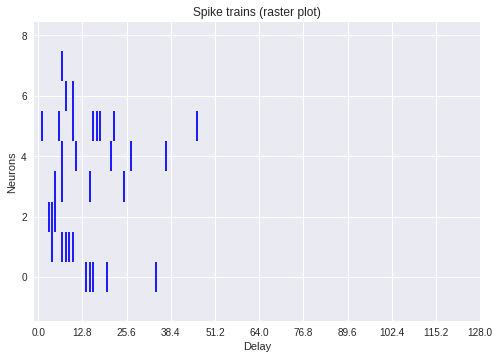

In [34]:
plot_raster(hist[25,:,:])

### Convert to continuous firing rate with running mean smoothing

Note that in the next plot, each neurone firing rate is offseted to display all neurons in the same graph.

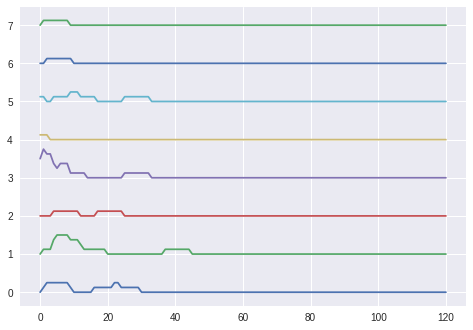

In [35]:
window = 8
hist_smooth  = np.zeros((hist.shape[0],hist.shape[1],hist.shape[2]-window+1))
for shot in range(hist.shape[0]):
    for ch in range(hist.shape[1]):
        # X_train_smooth[shot, ch, :] = preprocessing.normalize([running_mean(X_train_dev[shot, ch, :], window)])
        hist_smooth[shot, ch, :] = running_mean(hist[shot, ch, :], window)

for ch in range(hist_smooth.shape[1]):
        plt.plot(hist_smooth[0,ch,:]+ch)
        
plt.show()

### Let's visualize

In the next cell, we visualize the ralation between the first 3 principal components of the firing rate.

In [36]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

n_components = 3
pca_real = PCA(n_components=n_components)

ax = go.Figure()

for shot in range(50):
    temp = hist_smooth[shot]
    principalComponents = pca_real.fit_transform(np.swapaxes(temp,0,1))
    marker_dict=dict(
    size=2,
    color='blue',   # choose a colorscale
    opacity=0.8
    )
    ax.add_scatter3d(x=principalComponents[:,0], y=principalComponents[:,1], z=principalComponents[:,2],mode='markers', marker=marker_dict)


ax.show()




 * MIT License
 *
 * Copyright (c) 2022 SLAC National Accelerator Laboratory
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in all
 * copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
 * SOFTWARE.
 *
 * Authors : Berthié Gouin-Ferland
 * Last update : 2022-12-12
 *
 * Description : This notebook explores a computational neuromorphic approach to process the cookiebox data
